In [124]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [125]:
import pathlib

#tgz is a type of compressed folder, tar is a utility to collect many files into one archive file.
# #pathlib
# data_dir = tf.keras.utils.get_file('/Users/andrewhowe/Projects/Image-classifier/dataset2', extract=True)
# data_dir = pathlib.Path(data_dir).with_suffix('')
# print(data_dir)

In [126]:
data_dir = pathlib.Path("/Users/andrewhowe/Projects/Image-classifier/dataset2")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1122


In [127]:
# shine = list(data_dir.glob('shine/*.jpg'))
# print (shine[1])
# PIL.Image.open(str(shine[2]))

In [128]:
batch_size = 32
img_height = 180
img_width = 180

training_dataset, validating_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset="both", 
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)
class_names = training_dataset.class_names
print (training_dataset.class_names)

Found 1125 files belonging to 4 classes.
Using 900 files for training.
Using 225 files for validation.
['cloudy', 'rain', 'shine', 'sunrise']


In [129]:
#the images in the dataset is represented as a tensor of the shape (32, 180, 180, 3).
#This means 32 images, of shape 180x180x3 (last dimension refers to # of color channels. R G B.)
#labels represented as tensor of shape (32,) corresponding to the 32 images.
for images, labels in training_dataset:
    print (images.shape)
    print(labels.shape)
    break

#buffered prefetching - prevent I/O blocking.

#Dataset.cache keeps images in memory after they are loaded off the disk during first epoch. So we dont have to refetch after every epoch.
#Dataset.prefetch allows the preprocessing of data while the model execution is happening during training.
#tf.data.AUTOTUNE dynamically sets the buffer time during execution. this is used for prefetch.

training_dataset = training_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validating_dataset = validating_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

(32, 180, 180, 3)
(32,)


In [130]:
#Our RGB channel values are in [0, 255] range. we will standardize values to be in the 0, 1 range. 
#rescaling by dividing both values by 255.
#this will be applied when we create our model.
normalization_layer = layers.Rescaling(scale=1./255) # this is an example unused

In [131]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.RandomFlip(),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 45, 45, 64)       

In [132]:
training_history = model.fit(training_dataset, validation_data=validating_dataset,
                             epochs=14)

Epoch 1/14
29/29 [==============================] - 5s 145ms/step - loss: 0.9994 - accuracy: 0.6211 - val_loss: 0.9545 - val_accuracy: 0.5600
Epoch 2/14
29/29 [==============================] - 4s 121ms/step - loss: 0.5835 - accuracy: 0.7922 - val_loss: 0.4024 - val_accuracy: 0.8844
Epoch 3/14
29/29 [==============================] - 4s 122ms/step - loss: 0.4498 - accuracy: 0.8433 - val_loss: 0.4287 - val_accuracy: 0.8756
Epoch 4/14
29/29 [==============================] - 3s 121ms/step - loss: 0.3609 - accuracy: 0.8822 - val_loss: 0.4433 - val_accuracy: 0.8578
Epoch 5/14
29/29 [==============================] - 3s 120ms/step - loss: 0.3112 - accuracy: 0.8944 - val_loss: 0.4454 - val_accuracy: 0.8267
Epoch 6/14
29/29 [==============================] - 4s 124ms/step - loss: 0.2684 - accuracy: 0.9056 - val_loss: 0.3316 - val_accuracy: 0.8711
Epoch 7/14
29/29 [==============================] - 3s 121ms/step - loss: 0.2538 - accuracy: 0.9022 - val_loss: 0.2944 - val_accuracy: 0.9067
Epoch 

<function matplotlib.pyplot.show(close=None, block=None)>

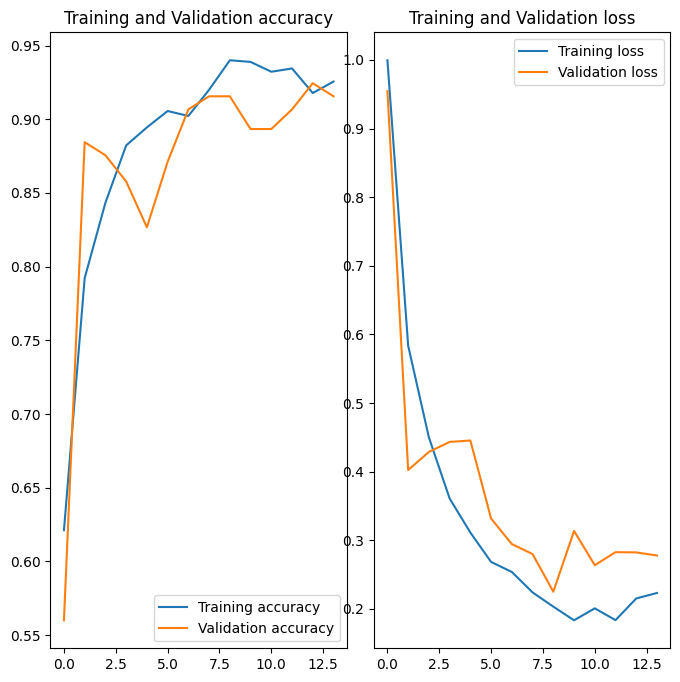

In [134]:
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
plt.figure(figsize=(8,8))
plt.subplot(1,4,(1,2)) 
plt.plot(range(14), acc, label='Training accuracy')
plt.plot(range(14), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1,4,(3,4))#this makes the subplots wider.
plt.plot(range(14), loss, label='Training loss')
plt.plot(range(14), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

plt.show


In [135]:
test_flower_url = "https://i.pinimg.com/originals/9d/51/a6/9d51a60e09a179ab8d22fa700bd36a0c.jpg"
test_flower_path = keras.utils.get_file('weather_image', test_flower_url)

img = keras.utils.load_img(test_flower_path, target_size=(img_height, img_width))
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    f"This image likely belongs to {class_names[np.argmax(score)]} with a {np.max(score)*100} percent confidence."
)

1/1 [==============================] - 0s 36ms/step
This image likely belongs to rain with a 97.29461073875427 percent confidence.
